# Spread Beta Factor

In [2]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

## Accessing backtest

In [4]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/CommodityInflationFactor/root/src")
from SpreadPCABetaFactor import SpreadPCABetaFactor
df = SpreadPCABetaFactor().generate_monthly_factor()

First start off with plotting each decile leg of each factor

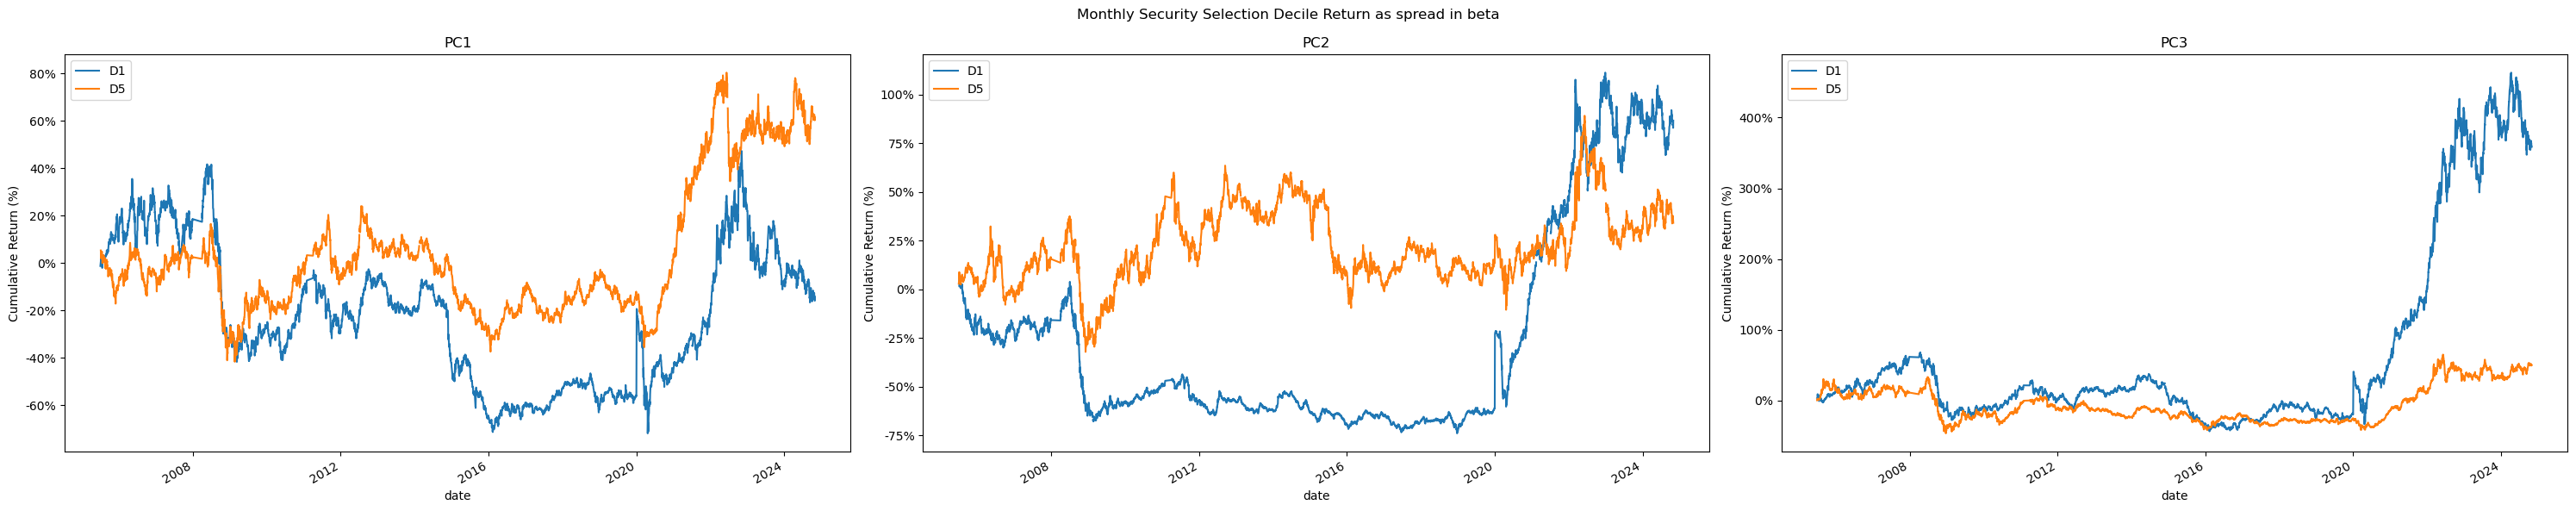

In [6]:
def plot_decile_return(df: pd.DataFrame) -> plt.Figure: 

    variables = df.pc.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(variables), figsize = (30,6))
    
    for variable, ax in zip(variables, axes.flatten()): 
    
        (df.query(
            "pc == @variable")
            [["date", "D1", "D5"]].
            melt(id_vars = "date").
            rename(columns = {"quartile": ""}).
            pivot(index = "date", columns = "", values = "value").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                title  = variable,
                ylabel = "Cumulative Return (%)"))
    
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))

    fig.suptitle("Monthly Security Selection Decile Return as spread in beta")
    plt.tight_layout()

plot_decile_return(df)

In [7]:
def get_decile_sharpe(df: pd.DataFrame) -> pd.DataFrame: 

    df_out = (df.melt(
        id_vars = ["date", "pc"]).
        drop(columns = ["date"]).
        groupby(["pc", "quartile"]).
        agg(["mean", "std"])
        ["value"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    return df_out

df_sharpe = get_decile_sharpe(df)

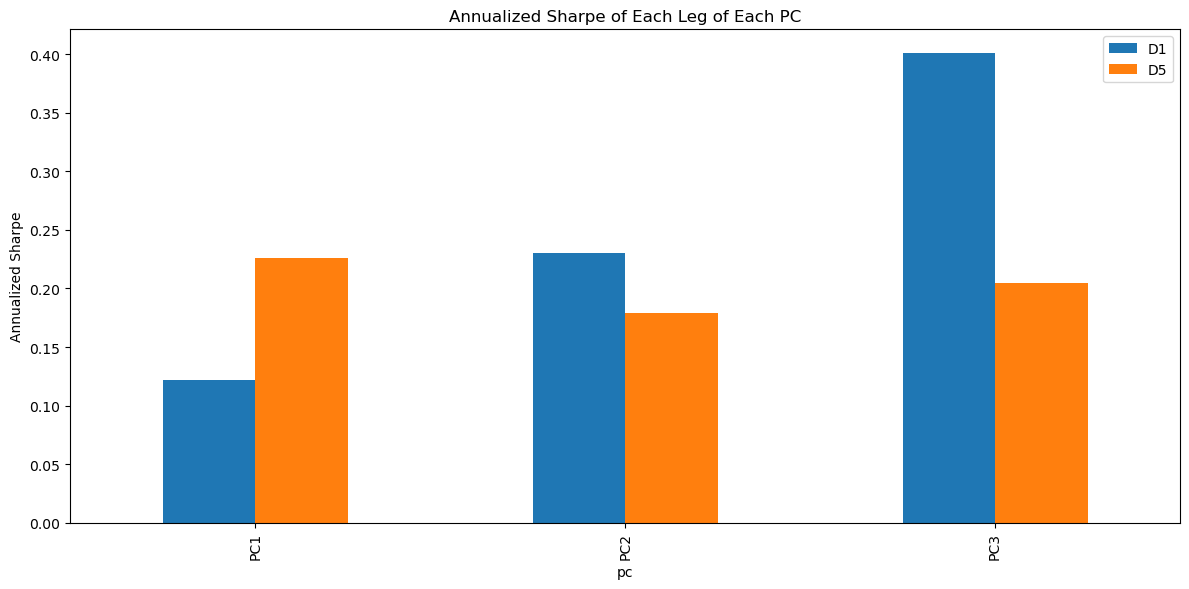

In [8]:
def plot_decile_sharpe(df_sharpe: pd.DataFrame) -> plt.Figure: 

    (df_sharpe[
        ["pc", "quartile", "sharpe"]].
        rename(columns = {"quartile": ""}).
        pivot(index = "pc", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            figsize = (12,6),
            ylabel  = "Annualized Sharpe",
            title   = "Annualized Sharpe of Each Leg of Each PC"))

    plt.tight_layout()

plot_decile_sharpe(df_sharpe)

Generate spread

In [10]:
def generate_spread(df: pd.DataFrame) -> pd.DataFrame: 

    df_d5d1 = (df.assign(
        spread      = lambda x: x.D5 - x.D1,
        spread_name = "D5 - D1"))
    
    df_d1d5 = (df.assign(
        spread      = lambda x: x.D1 - x.D5,
        spread_name = "D1 - D5"))
    
    df_combined = (pd.concat([
        df_d5d1, df_d1d5]).
        drop(columns = ["D1", "D5"]))

    return df_combined

df_spread = generate_spread(df)

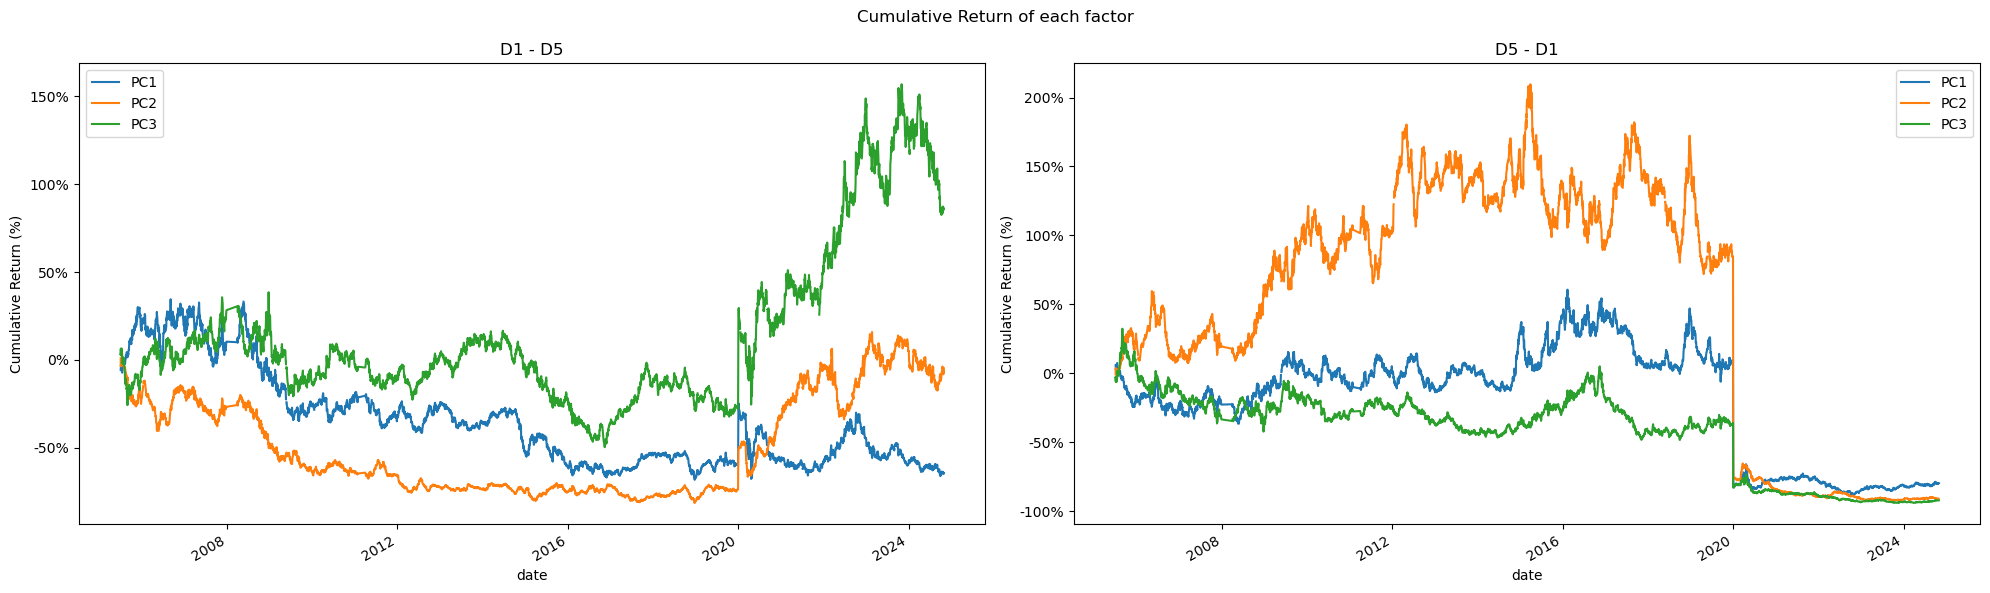

In [11]:
def plot_spread(df_spread: pd.DataFrame) -> plt.Figure:

    spreads   = df_spread.spread_name.drop_duplicates().sort_values().to_list()
    fig, axes = plt.subplots(ncols = len(spreads), figsize = (20,6))
    
    for spread, ax in zip(spreads, axes.flatten()): 
    
        (df_spread.query(
            "spread_name == @spread").
            drop(columns = ["spread_name"]).
            rename(columns = {"pc": ""}).
            pivot(index = "date", columns = "", values = "spread").
            apply(lambda x: np.cumprod(1 + x) - 1).
            plot(
                ax     = ax,
                ylabel = "Cumulative Return (%)",
                title  = spread))
    
        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: f"{x * 100:.0f}%"))
    
    fig.suptitle("Cumulative Return of each factor")
    plt.tight_layout()

plot_spread(df_spread)

In [12]:
def get_spread_sharpe(df_spread: pd.DataFrame) -> pd.DataFrame: 

    df_sharpe = (df_spread.drop(
        columns = ["date"]).
        groupby(["pc", "spread_name"]).
        agg(["mean", "std"])
        ["spread"].
        rename(columns = {
            "mean": "mean_rtn",
            "std" : "std_rtn"}).
        assign(sharpe = lambda x: x.mean_rtn / x.std_rtn * np.sqrt(252)).
        reset_index())

    return df_sharpe

df_spread_sharpe = get_spread_sharpe(df_spread)

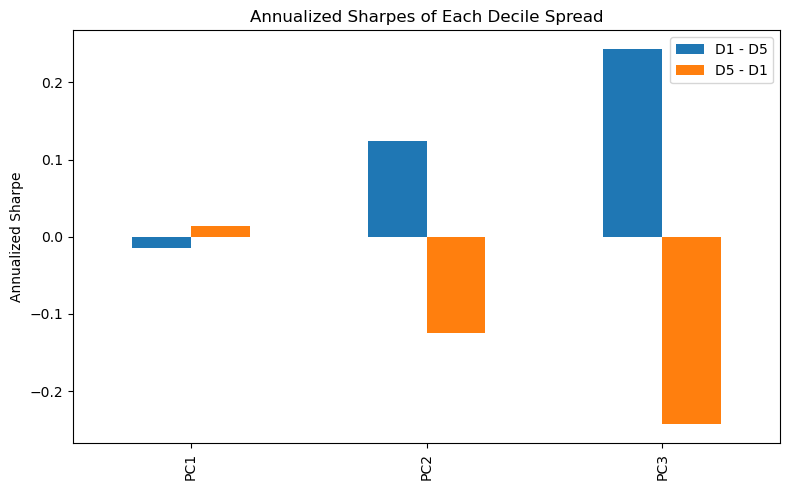

In [13]:
def plot_spread_sharpe(df_spread_sharpe: pd.DataFrame) -> plt.Figure: 


    (df_spread_sharpe.drop(
        columns = ["mean_rtn", "std_rtn"]).
        rename(columns = {"spread_name": ""}).
        pivot(index = "pc", columns = "", values = "sharpe").
        plot(
            kind    = "bar",
            ylabel  = "Annualized Sharpe",
            xlabel  = "",
            title   = "Annualized Sharpes of Each Decile Spread",
            figsize = (8,5)))

    plt.tight_layout()

plot_spread_sharpe(df_spread_sharpe)